In [1]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division
from sklearn.cluster import KMeans


import warnings
warnings.filterwarnings("ignore")

In [2]:


import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.offline as pyoff


In [3]:
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [4]:
sales = pd.read_csv('sales_data.csv')
sales.head()

,CustomerID,date,item_id,item_price,date_block_num,shop_id,item_cnt_day,Quantity,shipment
0,7311,02.01.2013,22154,999.00,0,59,1,2,1
1,1663,03.01.2013,2552,899.00,0,25,1,2,1
2,9376,05.01.2013,2552,899.00,0,25,-1,2,1
3,7634,06.01.2013,2554,1709.05,0,25,1,2,1
4,8808,15.01.2013,2555,1099.00,0,25,1,2,1


#### handling date in sales_data.csv

In [5]:
sales['date'] = pd.to_datetime(sales['date'])
sales['date'].describe()

count                  500000
unique                    151
top       2013-02-23 00:00:00
freq                     7577
first     2013-01-01 00:00:00
last      2013-12-05 00:00:00
Name: date, dtype: object

#### spliting based on time windom: 3 & 6 months

In [6]:
sales_3m = sales[(sales.date < datetime(2013,6,1)) & (sales.date >= datetime(2013,3,1))].reset_index(drop=True)

#6 months
sales_6m = sales[(sales.date >= datetime(2013,6,1)) & (sales.date < datetime(2013,12,1))].reset_index(drop=True)

In [7]:
sales_3m['date'].describe()


count                  216950
unique                     71
top       2013-03-01 00:00:00
freq                     6298
first     2013-03-01 00:00:00
last      2013-05-31 00:00:00
Name: date, dtype: object

In [8]:
sales_6m['date'].describe()


count                  104081
unique                     30
top       2013-08-03 00:00:00
freq                     6124
first     2013-06-01 00:00:00
last      2013-11-05 00:00:00
Name: date, dtype: object

##  taking 3 months of data, calculate RFM and use it for predicting next 6 months

#### finding unique customerid for 3 months

In [9]:
user = pd.DataFrame(sales_3m['CustomerID'].unique())
user.columns = ['CustomerID']

### Recency

In [10]:
max_purchase = sales_3m.groupby('CustomerID').date.max().reset_index()

In [11]:
max_purchase.columns =['CustomerID','maxPurchaseDate']

In [12]:
max_purchase['Recency'] = (max_purchase['maxPurchaseDate'].max() - max_purchase['maxPurchaseDate']).dt.days

In [13]:
user = pd.merge(user, max_purchase[['CustomerID','Recency']], on='CustomerID')
user.head()

,CustomerID,Recency
0,1663,6
1,9376,0
2,3289,2
3,3407,0
4,2618,8


In [14]:
user.Recency.describe()

count    9001.000000
mean        4.164093
std         4.959734
min         0.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        45.000000
Name: Recency, dtype: float64

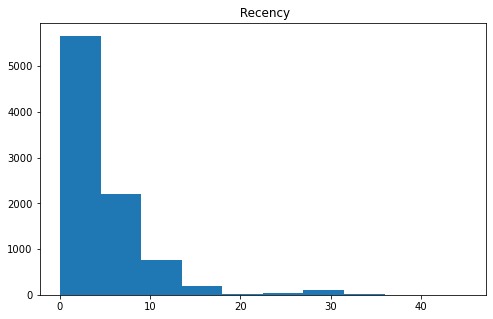

In [15]:
plt.figure(figsize=(8,5))
plt.hist(user['Recency'])

plt.title(' Recency')

plt.show()

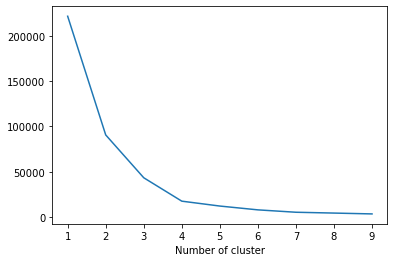

In [16]:
sse={}
recency = user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()


In [17]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Recency']])
user['RecencyCluster'] = kmeans.predict(user[['Recency']])

In [18]:
user.groupby('RecencyCluster')['Recency'].describe()


,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,5056.0,1.122824,1.100196,0.0,0.0,1.0,2.0,3.0
1,982.0,11.866599,2.407414,9.0,10.0,12.0,13.0,18.0
2,2805.0,5.579323,1.227886,4.0,5.0,5.0,6.0,8.0
3,158.0,28.487342,2.809759,26.0,27.0,27.0,30.0,45.0


In [19]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [20]:
user = order_cluster('RecencyCluster', 'Recency',user,False)
user.head()

,CustomerID,Recency,RecencyCluster
0,1663,6,2
1,2618,8,2
2,5262,4,2
3,9332,4,2
4,5587,7,2


### Frequency

In [21]:
frequency = sales_3m.groupby('CustomerID').date.count().reset_index()


In [22]:
frequency.columns = ['CustomerID','Frequency']
frequency.head()

,CustomerID,Frequency
0,1000,30
1,1001,17
2,1002,21
3,1003,33
4,1004,19


In [23]:
user = pd.merge(user, frequency, on='CustomerID')
user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,1663,6,2,24
1,2618,8,2,22
2,5262,4,2,27
3,9332,4,2,33
4,5587,7,2,34


In [24]:
user.Frequency.describe()

count    9001.000000
mean       24.102877
std         4.884997
min         7.000000
25%        21.000000
50%        24.000000
75%        27.000000
max        47.000000
Name: Frequency, dtype: float64

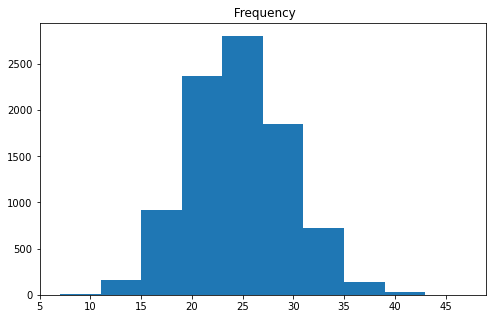

In [25]:
plt.figure(figsize=(8,5))
plt.hist(user.query('Frequency < 1000')['Frequency'])

plt.title(' Frequency')

plt.show()

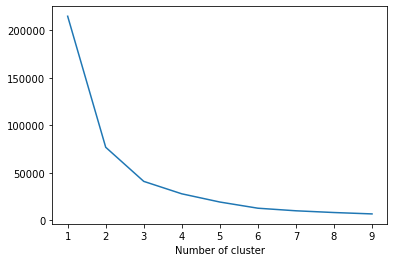

In [26]:
sse={}
frequency = user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(frequency)
    frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [27]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Frequency']])
user['FrequencyCluster'] = kmeans.predict(user[['Frequency']])

In [28]:
user.groupby('FrequencyCluster')['Frequency'].describe()


,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1675.0,31.327761,2.470260,29.0,29.0,31.0,32.0,47.0
1,1570.0,17.122930,1.979061,7.0,16.0,18.0,19.0,19.0
2,2618.0,21.619175,1.106710,20.0,21.0,22.0,23.0,23.0
3,3138.0,25.810707,1.380399,24.0,25.0,26.0,27.0,28.0


In [29]:
user = order_cluster('FrequencyCluster', 'Frequency',user,True)
user.tail()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
8996,8678,45,0,9,0
8997,7497,27,0,19,0
8998,2188,26,0,17,0
8999,7187,38,0,9,0
9000,4605,32,0,17,0


### Monetary Value

In [30]:
sales_3m['Revenue'] = sales_3m['item_price'] * sales_3m['Quantity']


In [31]:
revenue = sales_3m.groupby('CustomerID').Revenue.sum().reset_index()
revenue.head()

,CustomerID,Revenue
0,1000,32809.4
1,1001,23346.0
2,1002,22263.9
3,1003,36132.5
4,1004,18563.5


In [32]:
user = pd.merge(user, revenue, on='CustomerID')
user.Revenue.describe()

count      9001.000000
mean      32523.498449
std       13495.287109
min        5237.000000
25%       23342.000000
50%       30065.360000
75%       38324.400000
max      139925.431818
Name: Revenue, dtype: float64

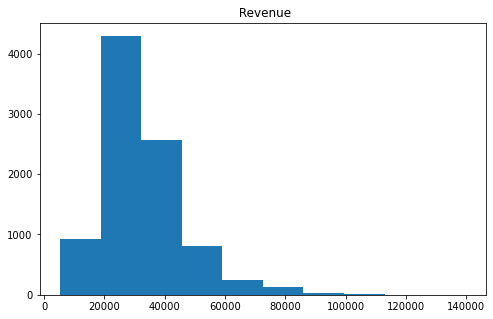

In [33]:
plt.figure(figsize=(8,5))
plt.hist(user.query('Revenue > 1000')['Revenue'])

plt.title(' Revenue')

plt.show()

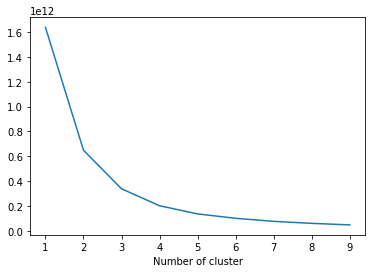

In [34]:
sse={}
revenue = user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(revenue)
    revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [35]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Revenue']])
user['RevenueCluster'] = kmeans.predict(user[['Revenue']])

In [36]:
user = order_cluster('RevenueCluster', 'Revenue',user,True)


In [37]:
user.groupby('RevenueCluster')['Revenue'].describe()


,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3357.0,20920.616366,4040.047167,5237.00,18247.000,21658.500000,24194.0,26677.750000
1,3665.0,32489.643192,3628.381862,26681.65,29381.000,32077.000000,35385.3,39885.560000
2,1608.0,47278.799827,5593.723142,39899.50,42486.525,46106.500001,51296.5,60660.030000
3,371.0,73893.929868,11484.284736,60720.10,65198.850,71153.500000,79625.7,139925.431818


### Overall Segmentation

In [38]:
user.tail()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
8996,2823,10,1,19,0,44240.00,2
8997,7152,18,1,15,0,40758.00,2
8998,9981,9,1,17,0,41439.40,2
8999,5069,13,1,18,0,51719.25,2
9000,6489,32,0,19,0,47851.00,2


In [39]:
user['OverallScore'] = user['RecencyCluster'] + user['FrequencyCluster'] + user['RevenueCluster']

In [40]:
user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()


,Recency,Frequency,Revenue
OverallScore,,,
0,28.566038,16.207547,18457.174407
1,15.388186,17.215190,19555.100297
2,8.810937,18.417188,20848.096854
3,5.180916,19.642748,22689.288101
4,4.201526,22.176097,26770.548488
5,3.431675,24.306461,31661.813385
6,2.441718,26.387117,36483.196077
7,2.057143,29.064069,43634.655966
8,1.443060,31.208185,52996.074265


In [41]:
user.groupby('OverallScore')['Recency'].count()


OverallScore
0      53
1     237
2     640
3    1310
4    1573
5    1749
6    1630
7    1155
8     562
9      92
Name: Recency, dtype: int64

In [42]:
user['Segment'] = 'Low-Value Customer'
user.loc[user['OverallScore']>2,'Segment'] = 'Mid-Value Customer' 
user.loc[user['OverallScore']>4,'Segment'] = 'High-Value Customer'

In [44]:
graph = user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=graph.query("Segment == 'Low-Value Customer'")['Frequency'],
        y=graph.query("Segment == 'Low-Value Customer'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'Mid-Value Customer'")['Frequency'],
        y=graph.query("Segment == 'Mid-Value Customer'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'High-Value Customer'")['Frequency'],
        y=graph.query("Segment == 'High-Value Customer'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
                      line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

### LTV

In [45]:
user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,1663,6,2,24,2,24754.00,0,4,Mid-Value Customer
1,9839,5,2,24,2,21180.34,0,4,Mid-Value Customer
2,8569,4,2,26,2,22452.50,0,4,Mid-Value Customer
3,7541,5,2,24,2,23643.50,0,4,Mid-Value Customer
4,1010,5,2,26,2,21953.90,0,4,Mid-Value Customer


In [46]:
sales_6m.head()

,CustomerID,date,item_id,item_price,date_block_num,shop_id,item_cnt_day,Quantity,shipment
0,7634,2013-06-01,2554,1709.05,0,25,1,2,1
1,4578,2013-10-01,2564,349.00,0,25,1,3,1
2,5104,2013-11-01,2572,299.00,0,25,1,3,1
3,6409,2013-07-01,2574,399.00,0,25,1,2,1
4,2649,2013-08-01,2574,399.00,0,25,2,2,1


In [47]:
sales_6m['Revenue'] = sales_6m['item_price'] * sales_6m['Quantity']


In [48]:
user_6m = sales_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
user_6m.columns = ['CustomerID','m6_Revenue']

In [49]:
sales_6m.head()

,CustomerID,date,item_id,item_price,date_block_num,shop_id,item_cnt_day,Quantity,shipment,Revenue
0,7634,2013-06-01,2554,1709.05,0,25,1,2,1,3418.1
1,4578,2013-10-01,2564,349.00,0,25,1,3,1,1047.0
2,5104,2013-11-01,2572,299.00,0,25,1,3,1,897.0
3,6409,2013-07-01,2574,399.00,0,25,1,2,1,798.0
4,2649,2013-08-01,2574,399.00,0,25,2,2,1,798.0


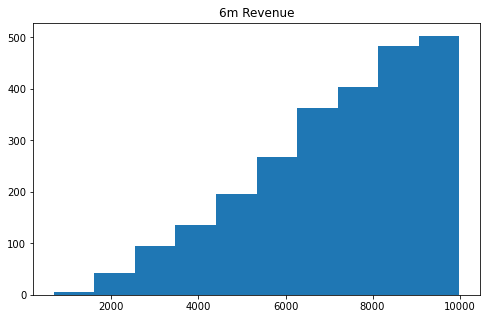

In [52]:
plt.figure(figsize=(8,5))
plt.hist(user_6m.query('m6_Revenue < 10000')['m6_Revenue'])

plt.title('6m Revenue')

plt.show()

In [54]:
merge = pd.merge(user, user_6m, on='CustomerID', how='left')
merge.tail()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
8996,2823,10,1,19,0,44240.00,2,3,Mid-Value Customer,33268.500000
8997,7152,18,1,15,0,40758.00,2,3,Mid-Value Customer,15807.818182
8998,9981,9,1,17,0,41439.40,2,3,Mid-Value Customer,14342.000000
8999,5069,13,1,18,0,51719.25,2,3,Mid-Value Customer,17208.000000
9000,6489,32,0,19,0,47851.00,2,2,Low-Value Customer,20964.500000


In [55]:
merge = merge.fillna(0)


In [56]:
merge.groupby('Segment')['m6_Revenue'].mean()


Segment
High-Value Customer    15629.106644
Low-Value Customer     15352.525329
Mid-Value Customer     15902.384045
Name: m6_Revenue, dtype: float64

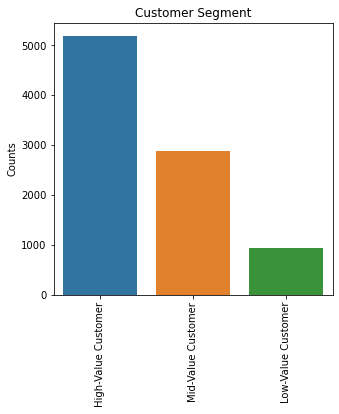

In [57]:
#Graph

customer_count = merge['Segment'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(5,5))
sns.barplot(customer_count.index, customer_count.values)
plt.ylabel("Counts")
plt.title("Customer Segment");
plt.xticks(rotation=90);

In [58]:
merge = merge[merge['m6_Revenue']<merge['m6_Revenue'].quantile(0.99)]


In [59]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(merge[['m6_Revenue']])
merge['LTVCluster'] = kmeans.predict(merge[['m6_Revenue']])

In [60]:
merge = order_cluster('LTVCluster', 'm6_Revenue',merge,True)


In [61]:
merge.groupby('LTVCluster')['m6_Revenue'].describe()


,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,4824.0,9584.849441,2998.207700,671.22,7434.750,9829.835,12051.985,14379.0
1,3420.0,19165.076811,3425.463027,14386.50,16257.700,18628.095,21528.810,27478.1
2,666.0,35787.195038,6807.503701,27511.00,30244.625,33674.575,40392.800,53186.5


In [62]:
cluster = merge.copy()
cluster.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,1663,6,2,24,2,24754.00,0,4,Mid-Value Customer,11874.44,0
1,9839,5,2,24,2,21180.34,0,4,Mid-Value Customer,2385.10,0
2,8569,4,2,26,2,22452.50,0,4,Mid-Value Customer,3168.00,0
3,1010,5,2,26,2,21953.90,0,4,Mid-Value Customer,10144.00,0
4,4488,6,2,24,2,23643.00,0,4,Mid-Value Customer,2385.00,0


In [63]:
cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,4824.0,9584.849441,2998.207700,671.22,7434.750,9829.835,12051.985,14379.0
1,3420.0,19165.076811,3425.463027,14386.50,16257.700,18628.095,21528.810,27478.1
2,666.0,35787.195038,6807.503701,27511.00,30244.625,33674.575,40392.800,53186.5


In [64]:
cluster.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,1663,6,2,24,2,24754.00,0,4,Mid-Value Customer,11874.44,0
1,9839,5,2,24,2,21180.34,0,4,Mid-Value Customer,2385.10,0
2,8569,4,2,26,2,22452.50,0,4,Mid-Value Customer,3168.00,0
3,1010,5,2,26,2,21953.90,0,4,Mid-Value Customer,10144.00,0
4,4488,6,2,24,2,23643.00,0,4,Mid-Value Customer,2385.00,0


In [65]:
sales_class = pd.get_dummies(cluster)
sales_class.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,m6_Revenue,LTVCluster,Segment_High-Value Customer,Segment_Low-Value Customer,Segment_Mid-Value Customer
0,1663,6,2,24,2,24754.00,0,4,11874.44,0,0,0,1
1,9839,5,2,24,2,21180.34,0,4,2385.10,0,0,0,1
2,8569,4,2,26,2,22452.50,0,4,3168.00,0,0,0,1
3,1010,5,2,26,2,21953.90,0,4,10144.00,0,0,0,1
4,4488,6,2,24,2,23643.00,0,4,2385.00,0,0,0,1


In [66]:
corr_matrix = sales_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster                     1.000000
m6_Revenue                     0.884130
Segment_Mid-Value Customer     0.019062
Recency                        0.006248
CustomerID                    -0.000337
FrequencyCluster              -0.002324
Frequency                     -0.002636
RecencyCluster                -0.002691
Revenue                       -0.006738
OverallScore                  -0.007840
Segment_High-Value Customer   -0.010725
Segment_Low-Value Customer    -0.011798
RevenueCluster                -0.011996
Name: LTVCluster, dtype: float64

In [67]:
X = sales_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = sales_class['LTVCluster']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)


In [73]:
ltv_xgb_model = xgb.XGBClassifier(max_depth=10, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

[23:49:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGB classifier on training set: 0.90
Accuracy of XGB classifier on test set: 0.50


In [74]:
sales_class.groupby('LTVCluster').CustomerID.count()/sales_class.CustomerID.count()


LTVCluster
0    0.541414
1    0.383838
2    0.074747
Name: CustomerID, dtype: float64

In [75]:
y_pred = ltv_xgb_model.predict(X_test)


In [76]:
print( classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.55      0.74      0.63      2446
           1       0.38      0.25      0.31      1680
           2       0.07      0.00      0.01       329

    accuracy                           0.50      4455
   macro avg       0.33      0.33      0.31      4455
weighted avg       0.45      0.50      0.46      4455

